In [1]:
# Technical libraries
import cvxpy as cp
import numpy as np
import numpy.matlib
from scipy import linalg
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy 
import scipy.fftpack
import proximal 

%matplotlib inline

# Proximal Operators for Nonnegative Inverse Problems

Study of the combination of different image regularizers with nonnegativity constraints.

# Index

1. [Introductionr](#Intro)
    1. [Proximal Operator](#Prox)
    2. [Nonnegativity Function](#Nonneg)
2. [$\mathrm{L^1}$](#L1)
3. [$\mathrm{L^2}$](#L2)
4. [Matrix Q](#MatQ)
5. [Evaluating](#Eval)

# <a name="Intro"></a>1. Introduction

The goal of the present notebook is to find how of common image regularizers combine with nonnegativity through the proximal operator. We will be studying regularizers likethe $\mathrm{L}^1$ and the $\mathrm{L}^2$ norm, and group sparsity.

## <a name="Prox"></a>1.A. Proximal Operator

The proximal operator of a function $f$ is:

$$\mathrm{prox}_f(v) = \arg \min_x(f(x)+\frac{1}{2\lambda}||x - v||_2^2)$$

This means that it will optimize an input vector $v$ with respect to a function, but adding the constraint that the result has to be *somewhat close* (by the minimization of the second term, and with *somewhat* parametrized by $\lambda$) to the original. 

The interest of the project is to see how common image regularizers combine with nonnegativity constraints. In particular, we will see wether:
$$\mathrm{prox}_{f} = \mathrm{prox}_{\delta_{\rm I\!R_+^N}}(\mathrm{prox}_{\Re})$$
or 
$$\mathrm{prox}_{f} = \mathrm{prox}_{\Re}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}})$$
where $f = \delta_{\rm I\!R_+^N} + \Re$,
for several regularizers, starting by the know cases of $\mathrm{L^1}$ and $\mathrm{L^2}$ norms. 

In some cases for which the $\mathrm{prox}$ is a point-wise operation, a plot of $v_i$ vs $x_i$ can be made, where $v_i$ is the $i^{th}$ element of $v$. In this cases, the previous equations can be provedor discarded analitically.  

## <a name="Nonneg"></a>1.B. Nonnegativity Function

The nonnegativity function $\delta$ is defined as:

$$\delta_{\rm I\!R_+^N} =
\begin{cases}
        0 if x \in \rm I\!R_+^N \\
        +\inf if x\notin \rm I\!R_+^N
     \end{cases}$$
     
Given the definition of the proximal operator, it is immediate to see that to solve the proximal operator, we have as constraint $x\in \rm I\!R_+^N$. As such, the first term vanishes (since $x\in \rm I\!R_+^N$, by definition $f(x) = 0$). As such, we arrive to:

$$prox_f(\rm I\!R_+^N(v)) = \arg \min_{x\in \rm I\!R_+^N}\left(\frac{1}{2}||x - v||_2^2\right)$$

Given that $v \in \rm I\!R_+^N$, then the $x\in \rm I\!R_+^N$ that minimizes the prox operator is simply the $x$ closest to $v$, but yet inside the domain imposed by the indicator function (indicator of nonnegativity). It is useless to include the parameter $\lambda$ in this proximal, as the minimization of squares is the only term present.

In the next cell we define the nonnegativity proximal operator, and then make a plot of $v_i$ vs $x_i$.

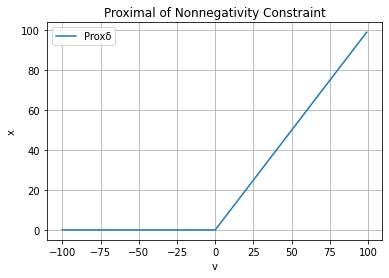

In [2]:
nonneg = lambda x: np.maximum(np.zeros_like(x), x)

vi = np.arange(-100, 100)
plt.figure()
plt.title('Proximal of Nonnegativity Constraint')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.plot(vi, list(map(nonneg, vi)), label = 'Prox\u03b4')
plt.legend()

# <a name = 'L1'></a> 2. L1 Norm
[Back to Index](#Index)

In this section we will prove the equations provided on [1.A](#Prox), for the $\mathrm{L}^1$ norm. It is a part from the family of the $L^p$ norms where $p = 1$, is defined for a vector $x$ as:
$$||x||_p = (\sum_{i = 1}^n x^p)^\frac{1}{p} $$

It follows that the $L^1$ norm of a vector is simply the sum of its components. It is a common image regularizer because it enforces sparsity, a well known property of natural images. 

### <a name = 'L1_Prox'></a> 2.A Proximal 
[Back to Index](#Index)

Following the definition of the Proximal operator:

$$\mathrm{prox}_{L^1}(v) = \arg \min_x(||x||_1 + \frac{1}{2\lambda}||x - v||_2^2))$$

An intuitive interpretation is that the solution $x$ will be one where each element $x_i$ of $x$ is pulled towards $0$ in order to minimize  the $L^1$ norm (clearly without crossing $0$), but still remaining close to $v$ (to reduce the squared term). How much is it pulled depends on the parameter $\lambda$.

It follows that the $\mathrm{prox}$ is indeed a point-wise operation, defined as:
\mathrm{}
$$\mathrm{prox}_{\lambda \mathrm{L}^1,}(x_i) = \mathrm{sign}(x_i)\mathrm{max}(|x_i| - \lambda, 0)$$
Run the next cell to show this effect.

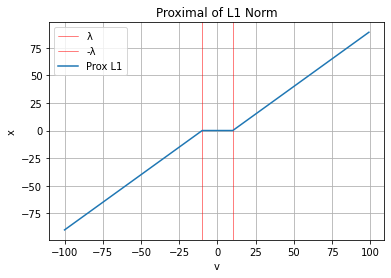

In [3]:
l1_prox = lambda x, lamb: np.sign(x)*np.maximum(np.abs(x) - lamb, 0)

lamb = 10
vi = np.arange(-100, 100)
plt.figure()
plt.title('Proximal of L1 Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.axvline(lamb, color='r', linewidth=0.5, label='\u03bb')
plt.axvline(-lamb, color='r', linewidth=0.5, label='-\u03bb')
plt.plot(vi, list(map(l1_prox, vi, np.ones_like(vi)*lamb)), label = 'Prox L1')
plt.legend()

### <a name = 'L1_Prox+Nonneg'></a> 2.B $\mathrm{L}^1$ + Nonneg
[Back to Index](#Index)

In this section we will compute the proximal operator of the $\mathrm{L}^1$ norm plus the nonnegativity constraint:
$$\mathrm{prox}_f(v)$$
where   
$$f(x) = ||x||_1 +  \delta_{\rm I\!R_+^N}$$

Following the definition from [section 1.B](#Proximal), and the derivation of the proximal from the nonnegativity constraint, it follows that:

$$\mathrm{prox}_{f}(v) = \arg \min_{x\in \rm I\!R_+^N}(||x||_1 + \frac{1}{2\lambda}||x - v||_2^2))$$

In this term we could add the function $\delta_{\rm_+^N}$, but since we have already defined $x\in \rm I\!R_+^N$, its value vanishes. 

From the constraint in the domain of $x$ and the structure of the $\mathrm{prox}_f(v)$, it is clear that the analytical solution with be similar to the solution of $\mathrm{prox}_{\mathrm{L^1}}(x)$, buth with the constraint in the domain applied:

$$\mathrm{prox}_{\lambda \mathrm{L}^1 + \delta_{\rm_+^N}}(v_i) = \mathrm{max}(v_i - \lambda, 0)$$

Run the next cell to define this function and plot it.

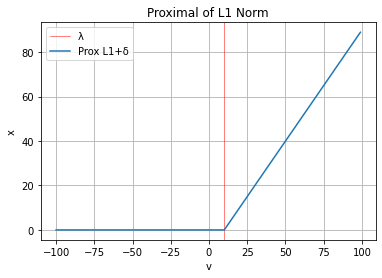

In [4]:
l1_plus_nonneg_prox = lambda x, lamb: np.maximum(x - lamb, 0)

lamb = 10

vi = np.arange(-100, 100)
plt.figure()
plt.title('Proximal of L1 Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.axvline(lamb, color='r', linewidth=0.5, label='\u03bb')
plt.plot(vi, list(map(l1_plus_nonneg_prox, vi, np.ones_like(vi)*lamb)), label='Prox L1+\u03b4')
plt.legend()

### <a name = 'Prox_L1(Prox(Nonneg))'></a> 2.C $\mathrm{prox}_{\mathrm{L}^1}(\mathrm{prox}_{\delta_{\rm I\!R_+^N }}(x))$
[Back to Index](#Index)

In this section we will:
 * Compute $\mathrm{prox}_{\mathrm{L}^1}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}}(x))$
 * Verify wether it is equal to $\mathrm{prox}_{\mathrm{L}^1\delta_{\rm I\!R_+^N}}(x))$
 
This is simply a composition of the two functions that we have already defined, `l1_prox` and `nonneg`. 

Run the next to apply both operators and plot them. Moreover, on the same plot we will plot $\mathrm{prox}_{\mathrm{L}^1\delta_{\rm_+}}(x))$, and verify wether it is the same.

prox_l1(prox_nonneg(v)) IS equal to prox(l1 + nonneg)


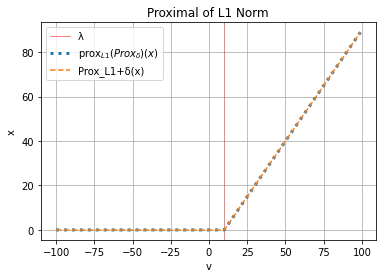

In [5]:
vi = np.arange(-100, 100)
nonneg_vect = list(map(nonneg, vi))
final_vect = list(map(l1_prox, nonneg_vect, np.ones_like(vi)*lamb))
l1_plus_nonneg_vect = list(map(l1_plus_nonneg_prox, vi, np.ones_like(vi)*lamb))
plt.figure()
plt.title('Proximal of L1 Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.axvline(lamb, color='r', linewidth=0.5, label='\u03bb')
plt.plot(vi, final_vect, ':', linewidth=3, label=r'$\mathrm{prox}_{L1}(Prox_\delta)(x)$')
plt.plot(vi, l1_plus_nonneg_vect, '--', label='Prox_L1+\u03b4(x)')
plt.legend()

if np.array_equal(final_vect, l1_plus_nonneg_vect):
    print(f'prox_l1(prox_nonneg(v)) IS equal to prox(l1 + nonneg)')
else:
    print(f'prox_l1(prox_nonneg(v)) IS NOT equal to prox(l1 + nonneg)')

### <a name = 'Prox_L1(Prox(Nonneg))'></a> 2.D $\mathrm{prox}_{\mathrm{L}^1}(\mathrm{prox}_{\delta_{\rm I\!R_+^N }}(x))$
[Back to Index](#Index)

In this section we will do the same as in last section but in the inverse order ($\mathrm{prox}_{\delta_{\rm I\!R_+^N}(\mathrm{prox}_{\mathrm{L}^1}}(x))$ instead of $\mathrm{prox}_{\mathrm{L}^1}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}}(x))$)

Run the next cell to see the results

prox_nonneg(prox_l1(v)) IS equal to prox(l1 + nonneg)


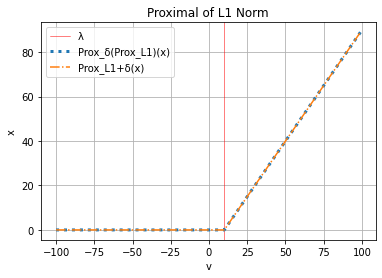

In [6]:
lamb = 10

vi = np.arange(-100, 100)
nonneg_vect = list(map(l1_prox, vi, np.ones_like(vi)*lamb))
final_vect = list(map(nonneg, nonneg_vect))
l1_plus_nonneg_vect = list(map(l1_plus_nonneg_prox, vi, np.ones_like(vi)*lamb))
plt.figure()
plt.title('Proximal of L1 Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.axvline(lamb, color='r', linewidth=0.5, label='\u03bb')
plt.plot(vi, final_vect, ':', linewidth=3, label='Prox_\u03b4(Prox_L1)(x)')
plt.plot(vi, l1_plus_nonneg_vect, '-.', label='Prox_L1+\u03b4(x)')
plt.legend()

if np.array_equal(final_vect, l1_plus_nonneg_vect):
    print(f'prox_nonneg(prox_l1(v)) IS equal to prox(l1 + nonneg)')
else:
    print(f'prox_nonneg(prox_l1(v)) IS NOT equal to prox(l1 + nonneg)')

# <a name = 'L2'></a> 3. L2 Norm
[Back to Index](#Index)

In this section we will prove the equations provided on [1.A](#Prox), for the $\mathrm{L}^2$ norm, in a similar way as we did in section [2](#L1). 

### <a name = 'L2_Prox'></a> 3.A Proximal 
[Back to Index](#Index)

The proximal operator of the L2 Norm is solved by projection onto the L2 unit ball $\Pi_B$, which follows from Moreau decomposition:

$$\mathrm{prox}_{L^2}(v) = v - \lambda \Pi_B\frac{v}{\lambda}$$

Thus, the projection $\Pi_B$ is simple. A vector $v$ remains unchanged if it is already inside $\Pi_B$, and it can be projected into the ball by normalizaation by its own norm otherwise. It is clear from the above that if the point $\frac{v}{\lambda}$ is within $\Pi_B$, the value of the $\mathrm{prox}_{L^2}(v)$ will vanish. Thus:

$$\mathrm{prox}_{L^2}(v) =
\begin{cases}
        (1 - \frac{\lambda}{||v||_2})v if ||v||_2 \geq \lambda \\
        0 if ||v||_2 < \lambda
     \end{cases}$$

It is clear that the only interesting scenario is when $||v||_2 \geq \lambda$. It follows that when $||v||_2$ is fixed, the $\mathrm{prox}$ is indeed a point-wise operation, defined as:
$$\mathrm{prox}_{\lambda \mathrm{L}^2,}(x_i) = (1 - \lambda v)$$
$$\mathrm{s.t.} \lambda < 1, ||v||_2 = 1 $$

However, if $||v||_2 \neq 1$ it is easy to generalize the $\mathrm{prox}$ of the L2 norm as a scaling a factor $1 - \frac{\lambda}{||v||_2}$.

Run the next cell to show $v$ vs $x$ for a parametrized version of the ($||v||_2 = 1$). Additionally, we will include the non-parametrized version

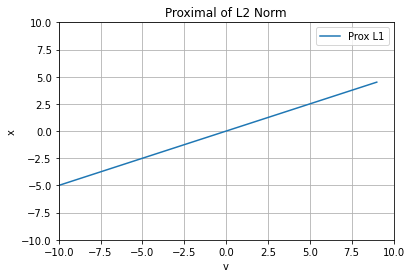

In [7]:
l2_prox_param = lambda x, lamb: (1 - np.minimum(lamb, np.ones_like(x)))*x
l2_prox = lambda x, lamb: (1 - np.minimum(lamb/np.linalg.norm(x, 2), np.ones_like(x)))*x
lamb = 0.5

vi = np.arange(-10, 10)
plt.figure()
plt.title('Proximal of L2 Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
plt.ylim([-10, 10])
plt.xlim([-10, 10])
plt.plot(vi, list(map(l2_prox_param, vi, np.ones_like(vi)*lamb)), label = 'Prox L1')
plt.legend()

### <a name = 'L2_Prox+Nonneg'></a> 3.B $\mathrm{L}^2$ + Nonneg
[Back to Index](#Index)

As we have already seen, the $\mathrm{prox}$ of $\delta_{\rm IR_+^N}$ imposes a constraint in the domain of the input vector $v$. Thus in this section we will compute the proximal operator of the $\mathrm{L}^1$ norm plus the nonnegativity constraint$^{[1]}$:

$$\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }}(v) = \left(1 - \frac{\lambda}{\mathrm{max}\left(||\mathrm{max}(x, 0)||_2, \lambda\right)} \right)\mathrm{max}(x, 0)$$

It is explicit from the formula that $\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N}}$ is acting on the projection into $\rm I\!R_+^N$. And thus, 

$$\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }} \neq \mathrm{prox}_{\mathrm{L}^2}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}})$$
whereas in general (except for very specific cases) 
$$\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }} = \mathrm{prox}_{\delta_{\rm I\!R_+^N}}(\mathrm{prox}_{\Re})$$

This case is clearly not a point wise operation independent of the input vector, and cannot be parametrized easily without loss of generalization (for we can assume a set of normalized vectors, but the norm will certainly change after applying nonnegativity constraints). Anyway, run the next cell to declare the correspinding map.

In [8]:
l2_plus_nonneg_prox = lambda x, lamb: (1 - lamb/(max(np.linalg.norm(np.maximum(x, 0), 2), np.max(lamb))))*np.maximum(x, 0)

## <a name = 'DCT'></a> 4. Minimization of $DCTx$

In this case we will try to minimiza an $f(x) = g(Qx)$. To begin with a simple case, we will choose $Q$ to be the [Discrete Cosine Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html),  which we know to be both orthogonal ($Q^TQ = QQ^T = I$) and real. Orthogonality has the advantage that it can be solved using the following property:
$$\mathrm{prox}_{\lambda f}(v) =  Q^T\mathrm{prox}_{\lambda g}(Qv)$$
where, in our case
$$f(x) = ||Qx||_1$$

### <a name = 'DCT_Prox'></a> 4.A Proximal

If we choose $f(x) = \|x\|_1$, then by [section 2.A](#L1_Prox), we have:
$$\mathrm{prox}_{\lambda f(x) = \|Qx\|_1}(v) = Q^T\mathrm{sign}(Qv)\odot \mathrm{max}(|Qv| - \lambda, 0)$$

If we fix the size of $\mathbf{v}$, this is evidently a pointwise operation. Run the next cell to declare $\mathrm{prox}_{\lambda f(x) = \|Qx\|_1}$ And plot the function as a point-wise operation (change the parameter $n$ to fix the isze of $\mathbf{v}$).  
<!-- $$f(x) = ||x||_1 +  \delta_{\rm I\!R_+^N}$$ -->

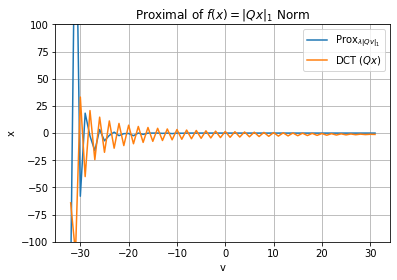

In [9]:
# Declare prox as a function of x (vector), Q (Matrix), lamb (parameter)
# l1_DCT_prox = lambda x, Q, lamb: Q.T @ np.sign(Q@x) * np.maximum(np.abs(Q@x) - lamb, 0)
def DCT_l1_prox(v, lamb): 
    Q = scipy.fftpack.dct(np.eye(len(v)), norm = 'ortho')
    return Q.T @ np.sign(Q@v) * np.maximum(np.abs(Q@v) - lamb, 0)

n = 64
v = np.arange(-n/2, n/2)
Q = scipy.fftpack.dct(np.eye(n), norm = 'ortho')
lamb = 5

plt.figure()
plt.title('Proximal of $f(x) = \|Qx\|_1$ Norm')
plt.grid()
plt.xlabel('v')
plt.ylabel('x')
# plt.axvline(lamb, color='r', linewidth=0.5, label='\u03bb')
# plt.axvline(-lamb, color='r', linewidth=0.5, label='-\u03bb')
plt.plot(v, DCT_l1_prox(v, lamb), label = '$\mathrm{Prox}_{\lambda \|Qv\|_1}$')
plt.plot(v, Q@v, label = 'DCT ($Qx$)')
plt.ylim([-100, 100])
# plt.plot(v, list(map(l1_prox, Q@v, np.ones_like(v)*lamb)), label = '$\mathrm{prox}_{\lambda\|Qx\|}$')

plt.legend()

### <a name = 'MatQ_Prox+Nonneg'></a> 4.B $\|Qx\|_1$ + Nonneg
[Back to Index](#Index)

$$f(x) = ||Qx||_1 +  \delta_{\rm I\!R_+^N}(x)$$

From the definition of the proximal operator:

$$\mathrm{prox}_f(v) = \arg \min_{x \in \rm I\!R_+^N}(\|Qx\|_1+\frac{1}{2}||x - v||_2^2)$$

The function $f(x)$ is no longer simply a composition function $f\circ g$ (the nonnegativity constraint acts on $x$, not on $Qx$). As such, it is not trivial to find a closed form solution, and we have to declare a function minimizing it as an optimization problem, solved by CVXPy. Run the following cell to declare this function.

In [10]:
def DCT_l1_plus_nonneg(v, lamb):
    
    # Get dimension of v
    n = len(v)
    # define DCT matrix
    DCT = scipy.fftpack.dct(np.eye(n), norm = 'ortho')
    # Define nonnegative constraint
    x = cp.Variable(n, nonneg = True) 
    # Define de the cost function
    obj = cp.norm(DCT@x, 1) + cp.sum_squares(x - v)/(2*lamb)
#     obj = cp.norm(scipy.fftpack.dct(x), 1) + cp.sum_squares(x - v)/(2*lamb)
#     DCT@x == scipy.fftpack.dct(x)
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    
    return x.value

## <a name = 'MatQ'></a> 5. Minimization of $\|Qx\|_1$

In this section we will try to minimize an $f(x) = g(Qx)$, but this time the general case, without making any assumptions on $Q$. 

### <a name = 'MatQ_Prox'></a> 5.A Proximal

By the definition of the proximal:
$$\mathrm{prox}_f(v) = \arg \min_{x}(\|Qx\|_1+\frac{1}{2}||x - v||_2^2)$$

Run the next cell to declare `Q_L1_prox`. In it, we will hard-code `Q`to be the finite differences matrix. 

In [11]:
def Q_L1_prox(v, lamb):
    
    # Get dimension of v
    n = len(v)
    
    # Declare Finite Differences
    vector = np.zeros((n,))
    vector[0] = 1
    vector[1] = -1
    idx = np.arange(n)
    Q = np.matlib.repmat(vector, n, 1)
    for i, row in enumerate(Q):
        Q[i] = np.roll(row, i)

    # Declare LoG
#     vector = np.zeros((n,))
#     vector[0] = 1
#     vector[1] = -2
#     vector[2] = 1
#     idx = np.arange(n)
#     Q = np.matlib.repmat(vector, n, 1)
#     for i, row in enumerate(Q):
#         Q[i] = np.roll(row, i)



    # Define variable
    x = cp.Variable(n) 
    # Define de the cost function
    obj = cp.norm(((Q@x)[:-1]), 1) + cp.sum_squares(x - v)/(2*lamb)

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    
    return x.value

### <a name = 'MatQ+Nonneg_Prox'></a> 5.B Minimization of $\|Qx\|_2 + \delta_{\rm IR_+^N}(x)$

In this section we will solve the proximal of $f(x) = \|Qx\|_2 + \delta_{\rm IR_+^N}(x)$

$$\mathrm{prox}_f(v) = \arg \min_{x \in \rm IR_+^N}(\|Qx\|_1+\frac{1}{2 \lambda}||x - v||_2^2)$$

Run the next cell to declare `Q_L1_plus_nonneg_prox`. In it, we will hard-code `Q`to be the finite differences matrix. 

In [12]:
def Q_L1_plus_nonneg_prox(v, lamb):
    
    # Get dimension of v
    n = len(v)
    
#     # Declare Finite Differences
    vector = np.zeros((n,))
    vector[0] = 1
    vector[1] = -1
    idx = np.arange(n)
    Q = np.matlib.repmat(vector, n, 1)
    for i, row in enumerate(Q):
        Q[i] = np.roll(row, i)

#     # Declare LoG
#     vector = np.zeros((n,))
#     vector[0] = 1
#     vector[1] = -2
#     vector[2] = 1
#     idx = np.arange(n)
#     Q = np.matlib.repmat(vector, n, 1)
#     for i, row in enumerate(Q):
#         Q[i] = np.roll(row, i)
        
    # Define variable
    x = cp.Variable(n, nonneg = True) 
    # Define de the cost function
    ########################## Buscar si soporta NumPy functions, ScipY, etc... ########
    obj = cp.norm(((Q@x)[:-1]), 1) + cp.sum_squares(x - v)/(2*lamb)

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    
    return x.value

# <a name = 'L2'></a> 6. L0 Norm
[Back to Index](#Index)

In this section we will prove the equations provided on [1.A](#Prox), for the $\mathrm{L}^0$ norm, in a similar way as we did in section [2](#L1). 

It is defined as:

### <a name = 'L2_Prox'></a> 6.A Proximal 
[Back to Index](#Index)


In [13]:
def l0_prox(x, lamb):
    x[np.absolute(x) < np.sqrt(2*lamb)] = 0
    return x

In [14]:
def l0_plus_nonneg_prox(v, lamb):
    
    # Get dimension of v
    n = len(v)
    
    # Define variable
    x = cp.Variable(n, nonneg = True) 
    # Define de the cost function
    ########################## Buscar si soporta NumPy functions, ScipY, etc... ########
    obj = cp.norm((x), 0) + cp.sum_squares(x - v)/(2*lamb)

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    
    return x.value

def l0_plus_nonneg_prox(x, lamb): 
    x[x < np.sqrt(2*lamb)] = 0
    return x

# <a name = 'Eval'></a> Evaluation

The following function `evaluate` is designed to evaluate a number of random vectors created from normal distributions on the cases presented in [section 1](#Intro):

$$\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }} $$
$$ \mathrm{prox}_{\mathrm{L}^2}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}})$$ 
$$\mathrm{prox}_{\delta_{\rm I\!R_+^N}}(\mathrm{prox}_{\mathcal{R}})$$

And searches for equality. It takes as input parameters:
* `reg` (function): Closed-form solution of the proximal operator of the regularizer, **Considerar como input problema CVXPY**
* `reg_nonneg` (function): Closed-form solution of the proximal operator of the regularizer + $\delta_{\rm I\!R_+^N }$,
* `n` (int): Number of vectors
* `shape` (tuple): Shape of the vectors
* `mean` (scalar): Mean of the vectors
* `sigma` (scalar): $\sigma$ of the normal distribution used to sample the vectors
* `lamb` (scalar): Parameter $\lambda$ to be used in the pointwise operations.

It returns:
* `reg_nonneg` (boolean): The findings on whether $\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }} == \mathrm{prox}_{\mathrm{L}^2}(\mathrm{prox}_{\delta_{\rm I\!R_+^N}})$
* `nonneg_reg` (boolean): The findings on whether
$\mathrm{prox}_{L^2 + \delta_{\rm I\!R_+^N }} == \mathrm{prox}_{\delta_{\rm I\!R_+^N}}(\mathrm{prox}_{\Re})$

Now we will run the function for the L1 and L2 norm

L2 Norm:
For the given regularizer, $\mathrm{prox}_{\delta}(\mathrm{prox}_{\mathcal{R}})$ IS NOT equal to prox(reg + nonneg)
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
Plotting example


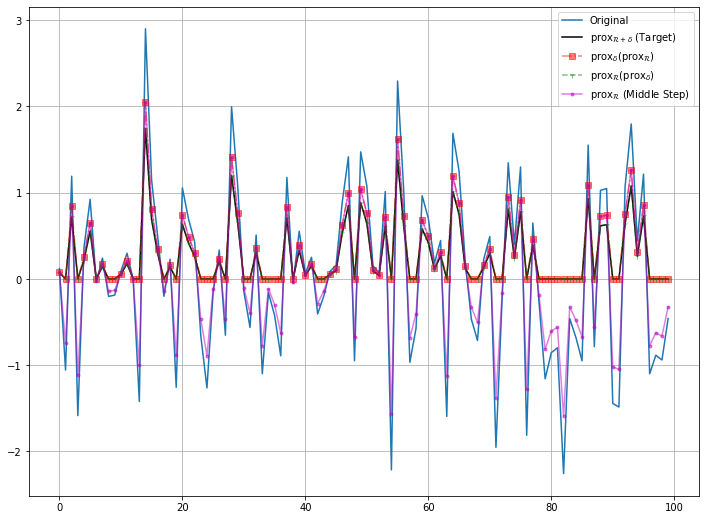


L1 Norm:
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
Plotting example


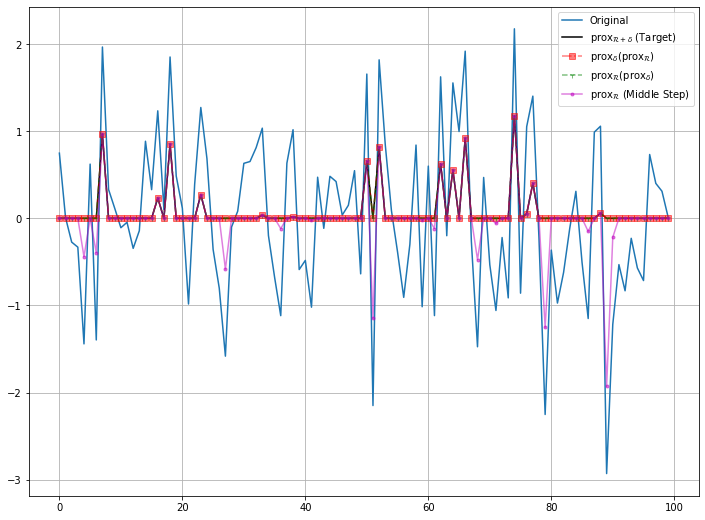


||Qx||1 Norm, where Q is the DCT:
For the given regularizer, $\mathrm{prox}_{\delta}(\mathrm{prox}_{\mathcal{R}})$ IS NOT equal to prox(reg + nonneg)
For the given regularizer, $\mathrm{prox}_{\delta}(\mathrm{prox}_{\mathcal{R}})$ IS NOT equal to prox(reg + nonneg)
Plotting example


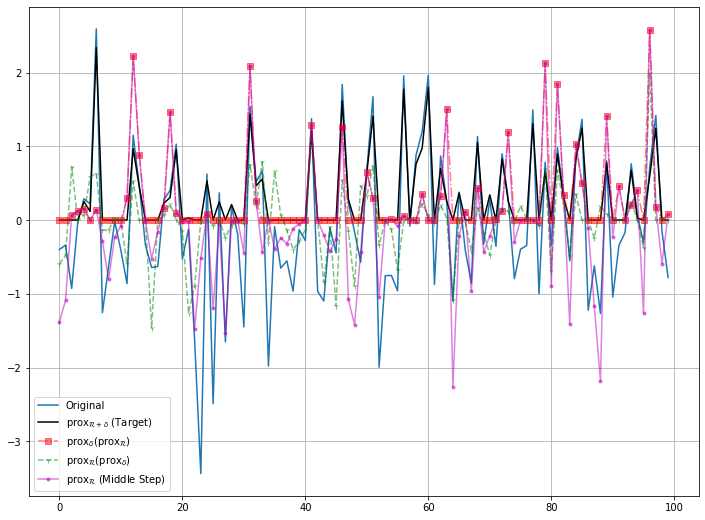


||Qx||1 Norm, where Q is the finite differences:
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
For the given regularizer, $\mathrm{prox}_{\delta}(\mathrm{prox}_{\mathcal{R}})$ IS NOT equal to prox(reg + nonneg)
Plotting example


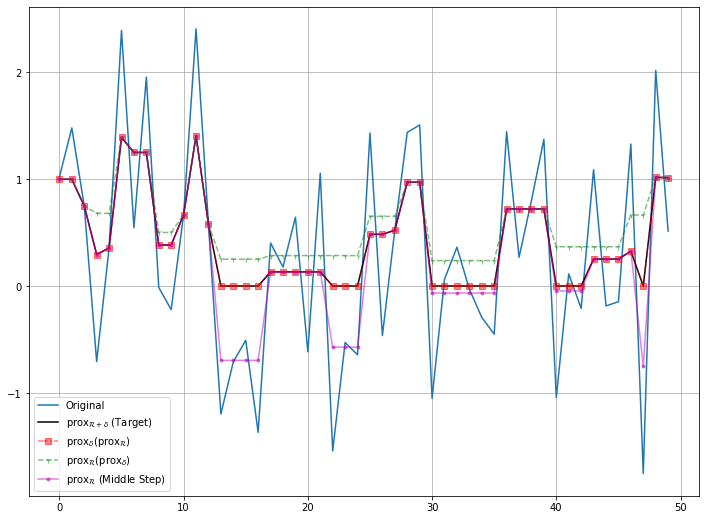


$||x||_0$ Norm
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
For the given regularizer, $\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$ SEEMS equal to prox(reg + nonneg)
Plotting example


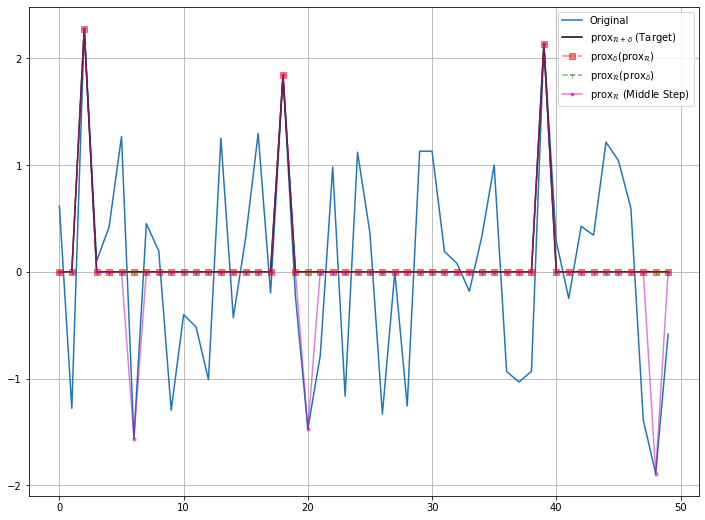

(True, True)

In [15]:
print('L2 Norm:')
proximal.evaluate(l2_prox, l2_plus_nonneg_prox, n=100, size=(100,), mean=0, sigma=1, lamb=3, plot=True )
print('\nL1 Norm:')
proximal.evaluate(l1_prox, l1_plus_nonneg_prox, n=100, size=(100,), mean=0, sigma=1, lamb=1, plot=True )
print('\n||Qx||1 Norm, where Q is the DCT:')
proximal.evaluate(DCT_l1_prox, DCT_l1_plus_nonneg, n=100, size=(100,), mean=0, sigma=1, lamb=0.1, plot=True )
print('\n||Qx||1 Norm, where Q is the finite differences:')
proximal.evaluate(Q_L1_prox, Q_L1_plus_nonneg_prox, n=10, size=(50,), mean=0, sigma=1, lamb=0.5, plot = True,
                  rtol=1e-2, atol=1e-3)
print('\n$||x||_0$ Norm')
proximal.evaluate(l0_prox, l0_plus_nonneg_prox, n=10, size=(50,), mean=0, sigma=1, lamb=1, plot = True,
                  rtol=1e-2, atol=1e-3)

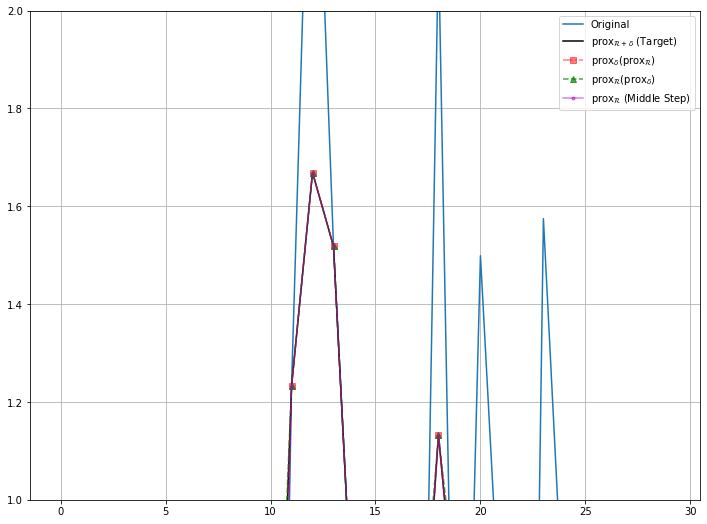

In [95]:
v = np.random.normal(loc=0, scale=1, size=(30,))
# Calculate prox_{reg+nonneg}()), prox_reg(prox_nonneg) and prox_nonneg(prox_ref) in that order
# Try will do the job for functions that perform element wise comparisons

lamb = 0.5

try:
    reg_plus_nonneg_vect = Q_L1_plus_nonneg_prox(np.copy(v), np.ones_like(v)*lamb)
    reg_o_nonneg_vect = Q_L1_prox(nonneg(np.copy(v)), np.ones_like(v)*lamb)
    nonneg_o_reg_vect = nonneg(Q_L1_prox(np.copy(v), np.ones_like(v)*lamb))
# Except will do the job for CVXPy
except:
    reg_plus_nonneg_vect = Q_L1_plus_nonneg_prox(np.copy(v), lamb)
    reg_o_nonneg_vect = Q_L1_prox(nonneg(np.copy(v)), lamb)
    nonneg_o_reg_vect = nonneg(Q_L1_prox(np.copy(v), lamb))

# if not(np.allclose(reg_plus_nonneg_vect, reg_o_nonneg_vect, rtol=rtol, atol=atol)) and reg_nonneg_bool:
#     reg_nonneg_bool = False
# if not(np.allclose(reg_plus_nonneg_vect, nonneg_o_reg_vect, rtol=rtol, atol=atol)) and nonneg_reg_bool:
#     nonneg_reg_bool = False

plt.figure(figsize = (12, 9))
plt.plot(v, label = 'Original')
plt.plot(reg_plus_nonneg_vect, 'k-', label = '$\mathrm{prox}_{\mathcal{R} + \delta}$ (Target)')
plt.plot(nonneg_o_reg_vect, 'rs-.', label = '$\mathrm{prox}_{\delta}(\mathrm{prox}_{\mathcal{R}})$', alpha = 0.5)
plt.plot(reg_o_nonneg_vect, 'g^--', label = '$\mathrm{prox}_{\mathcal{R}}(\mathrm{prox}_{\delta})$', alpha = 0.7)
plt.plot(Q_L1_prox(np.copy(v),  lamb), 'm.-', label = '$\mathrm{prox}_{\mathcal{R}}$ (Middle Step)', alpha = 0.5)
plt.grid()
plt.ylim([1, 2])
plt.legend()

$\mathrm{prox}_{\mathcal{R} + \delta_{\rm I\!R_+^N}}$

## References

[1](https://arc.aiaa.org/doi/pdf/10.2514/1.26320?casa_token=EpyiTfodqo4AAAAA%3AGmnFHyrImbNxMMk2ONs1c9wpN6bLTip8_a7irQweswoms0vMBtL1kGu6h8v6IK76_zhhhtk0KPA&) Pol del Aguila Pla and Joakim Jaldén, Cell detection by functional inverse diffusion and non-negative group sparsity—Part II: Proximal optimization and Performance evaluation, IEEE Transactions on Signal Processing, vol. 66, no. 20, pp. 5422–5437, 2018